In [1]:
# Imports 
from AI_testing_Kfold_3 import UNetModel, SomeMetrics, UNetNDeepResidual, DataGen
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import os
import numpy as np

2023-11-26 10:22:22.449118: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 10:22:22.453723: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 10:22:22.497333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 10:22:22.497366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 10:22:22.498875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Compiling the model
Unet = UNetNDeepResidual()
model = Unet.ResUNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         304       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

In [3]:
# Loading the data
data = DataGen()
x, y = data.Give_data()
print(x.shape, y.shape)

(444, 256, 256, 2) (444, 256, 256, 1)


In [4]:
model.fit(x, y, epochs=200)

Epoch 1/200
14/14 [==============================] - 59s 3s/step - loss: 0.2580 - acc: 0.9106
Epoch 2/200
14/14 [==============================] - 45s 3s/step - loss: 0.0384 - acc: 0.9912
Epoch 3/200
14/14 [==============================] - 45s 3s/step - loss: 0.0323 - acc: 0.9915
Epoch 4/200
14/14 [==============================] - 44s 3s/step - loss: 0.0294 - acc: 0.9922
Epoch 5/200
14/14 [==============================] - 44s 3s/step - loss: 0.0278 - acc: 0.9922
Epoch 6/200
14/14 [==============================] - 43s 3s/step - loss: 0.0261 - acc: 0.9925
Epoch 7/200
14/14 [==============================] - 44s 3s/step - loss: 0.0252 - acc: 0.9926
Epoch 8/200
14/14 [==============================] - 44s 3s/step - loss: 0.0269 - acc: 0.9918
Epoch 9/200
14/14 [==============================] - 44s 3s/step - loss: 0.0252 - acc: 0.9924
Epoch 10/200
14/14 [==============================] - 44s 3s/step - loss: 0.0232 - acc: 0.9931
Epoch 11/200
14/14 [==============================] - 43s 3

In [4]:
# Defining the Kfold
num_folds = 5
kf = KFold(n_splits=num_folds)

In [ ]:
# Training the model with kfold
results = []

for fold, (train_index, val_index) in enumerate(kf.split(x)):
    print(f'Training on fold {fold + 1}/{num_folds}...')

    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(x_train, y_train, epochs=100)

    scores = model.evaluate(x_val, y_val)
    results.append(scores)
results = np.array(results)

In [5]:
def Initial_maniplation():
    main_path = '/home/avoyeux/AI_tests/'
    image = tf.io.read_file(os.path.join(main_path, 'masks_sum_colors.png'))
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [256, 256])

    target_color = np.array([38, 255, 255])
    initial_filter = np.all(image == target_color, axis=-1)
    return initial_filter
initial_filter = Initial_maniplation()
print(initial_filter.shape)

(256, 256)


In [6]:
# importing the non used data
img_paths = sorted(Path('/home/avoyeux/AI_tests/Inputs').glob('*.png'))
img_paths2 = sorted(Path('/home/avoyeux/AI_tests/Inputs2').glob('*.png'))
mask_paths = sorted(Path('/home/avoyeux/AI_tests/New_masks').glob('*.png'))

img_paths = [str(path) for path in img_paths]
img_paths2 = [str(path) for path in img_paths2]
mask_paths = [str(path) for path in mask_paths]

img_paths = img_paths[:4]
img_paths2 = img_paths2[:4]
mask_paths = mask_paths[:4]

images, masks = [], []
for number, img_path in enumerate(img_paths):
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 255
        image = np.array(image)
        image[initial_filter] = 0

        image2 = tf.io.read_file(img_paths2[number])
        image2 = tf.image.decode_png(image2, channels=3)
        image2 = tf.image.rgb_to_grayscale(image2)
        image2 = tf.image.resize(image2, [256, 256])
        image2 = tf.cast(image2, tf.float32) / 255
        image2 = np.array(image2)
        image2[initial_filter] = 0

        mask = tf.io.read_file(mask_paths[number])
        mask = tf.image.decode_png(mask, channels=3)
        mask = tf.image.rgb_to_grayscale(mask)
        mask = tf.image.resize(mask, [256, 256])
        mask = tf.cast(mask, tf.float32) / 255
        mask = np.array(mask)
        mask[mask < 1] = 0
        mask[initial_filter] = 0
        
        image_tot = np.concatenate((image, image2), axis=2)
        images.append(image_tot)
        masks.append(mask)
images = np.array(images)
masks = np.array(masks)
print(images.shape)
print(np.min(images), np.max(images))

(4, 256, 256, 2)
0.0 1.0


In [7]:
model.save_weights('Unet_kfold_deepres/UnetW_nofold_deepres_epoch200_augmentation_maskval1.h5')
result1 = model.predict(images)
result2 = result1 > 0.1

1/1 [==============================] - 1s 796ms/step


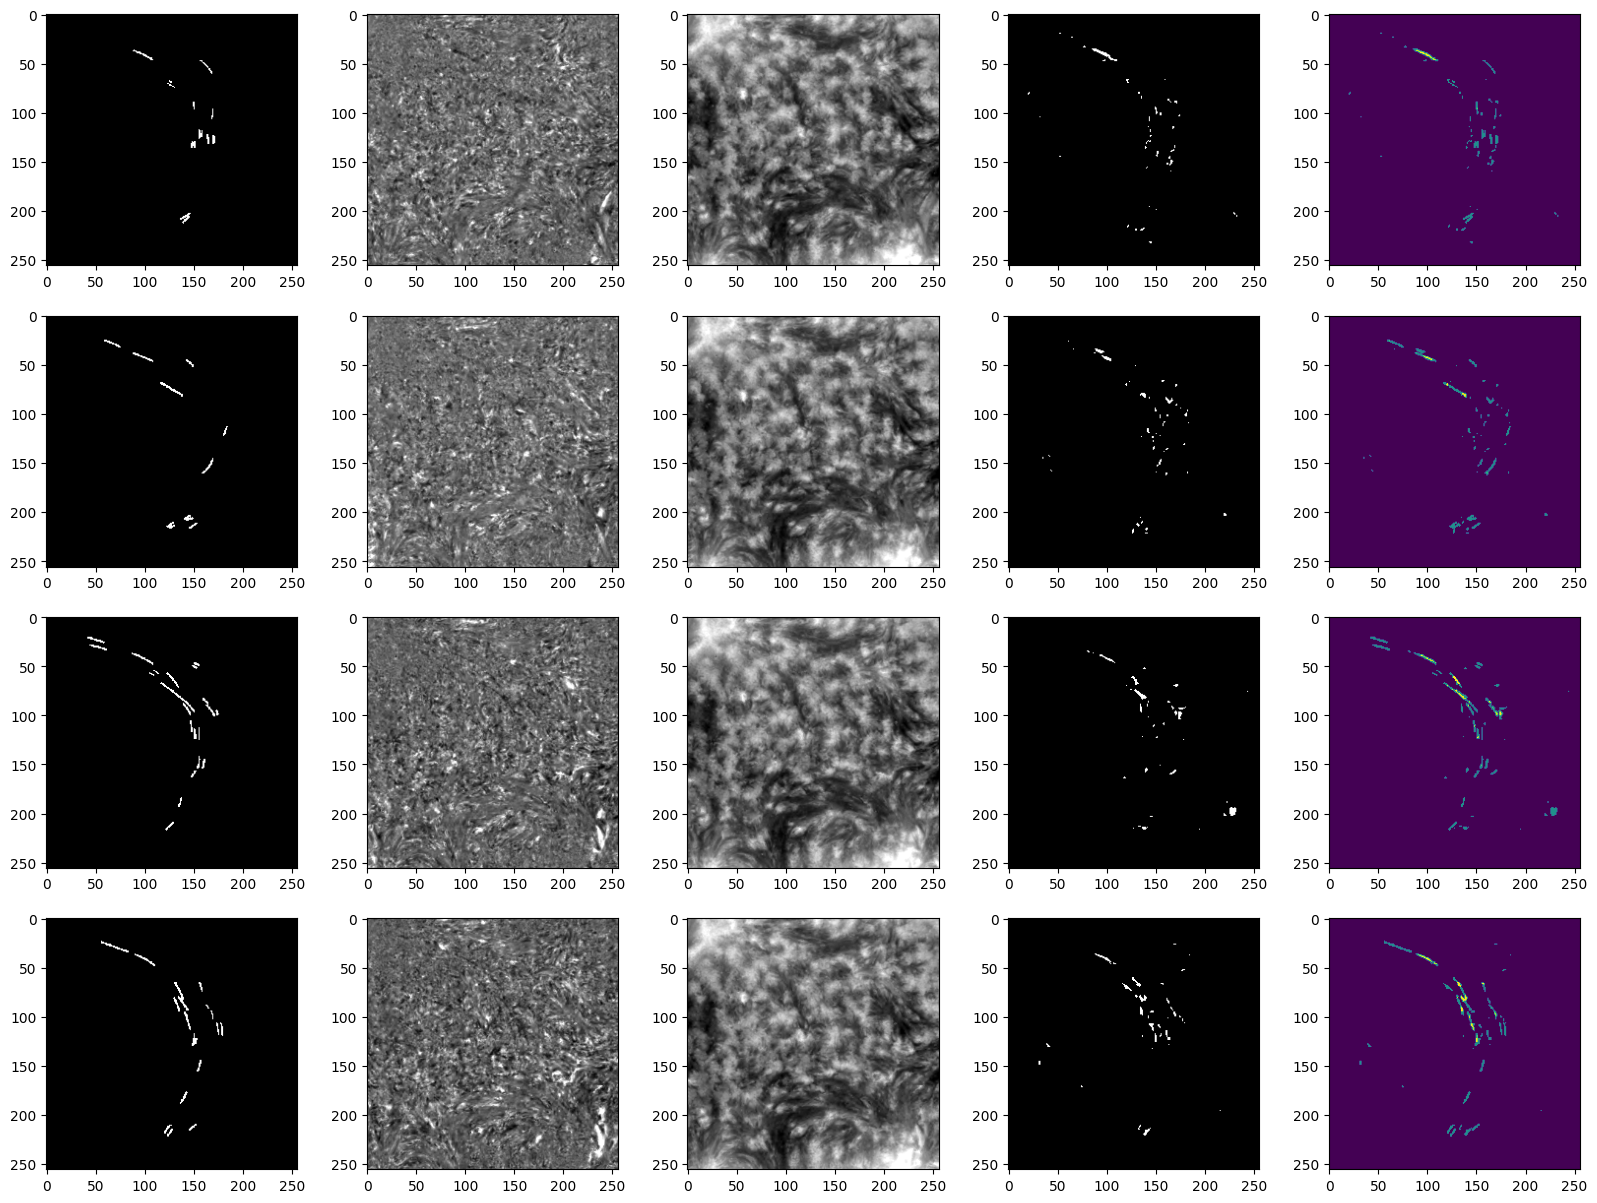

In [8]:
fig = plt.figure(figsize=(20, 15))
a = 0
for loop in range(4):
    for loop2 in range(5):
        a += 1
        ax = fig.add_subplot(4, 5, a)
        if loop2 == 0:
            ax.imshow(np.reshape(masks[loop] * 255, (256, 256)), cmap='gray')
        elif loop2 == 1:
            ax.imshow(np.reshape(images[loop, :, :, 0] * 255, (256, 256)), cmap='gray')
        elif loop2 == 2:
            ax.imshow(np.reshape(images[loop, :, :, 1] * 255, (256, 256)), cmap='gray')
        elif loop2 == 3:
            ax.imshow(np.reshape(result2[loop] * 255, (256, 256)), cmap='gray')
        else:
            ax.imshow(np.reshape((masks[loop] + result2[loop]) * 255, (256, 256)))

plt.savefig('Unet_kfold_deepres/plot_augmentation_epoch200_nofold_maskval1.png', dpi=300)

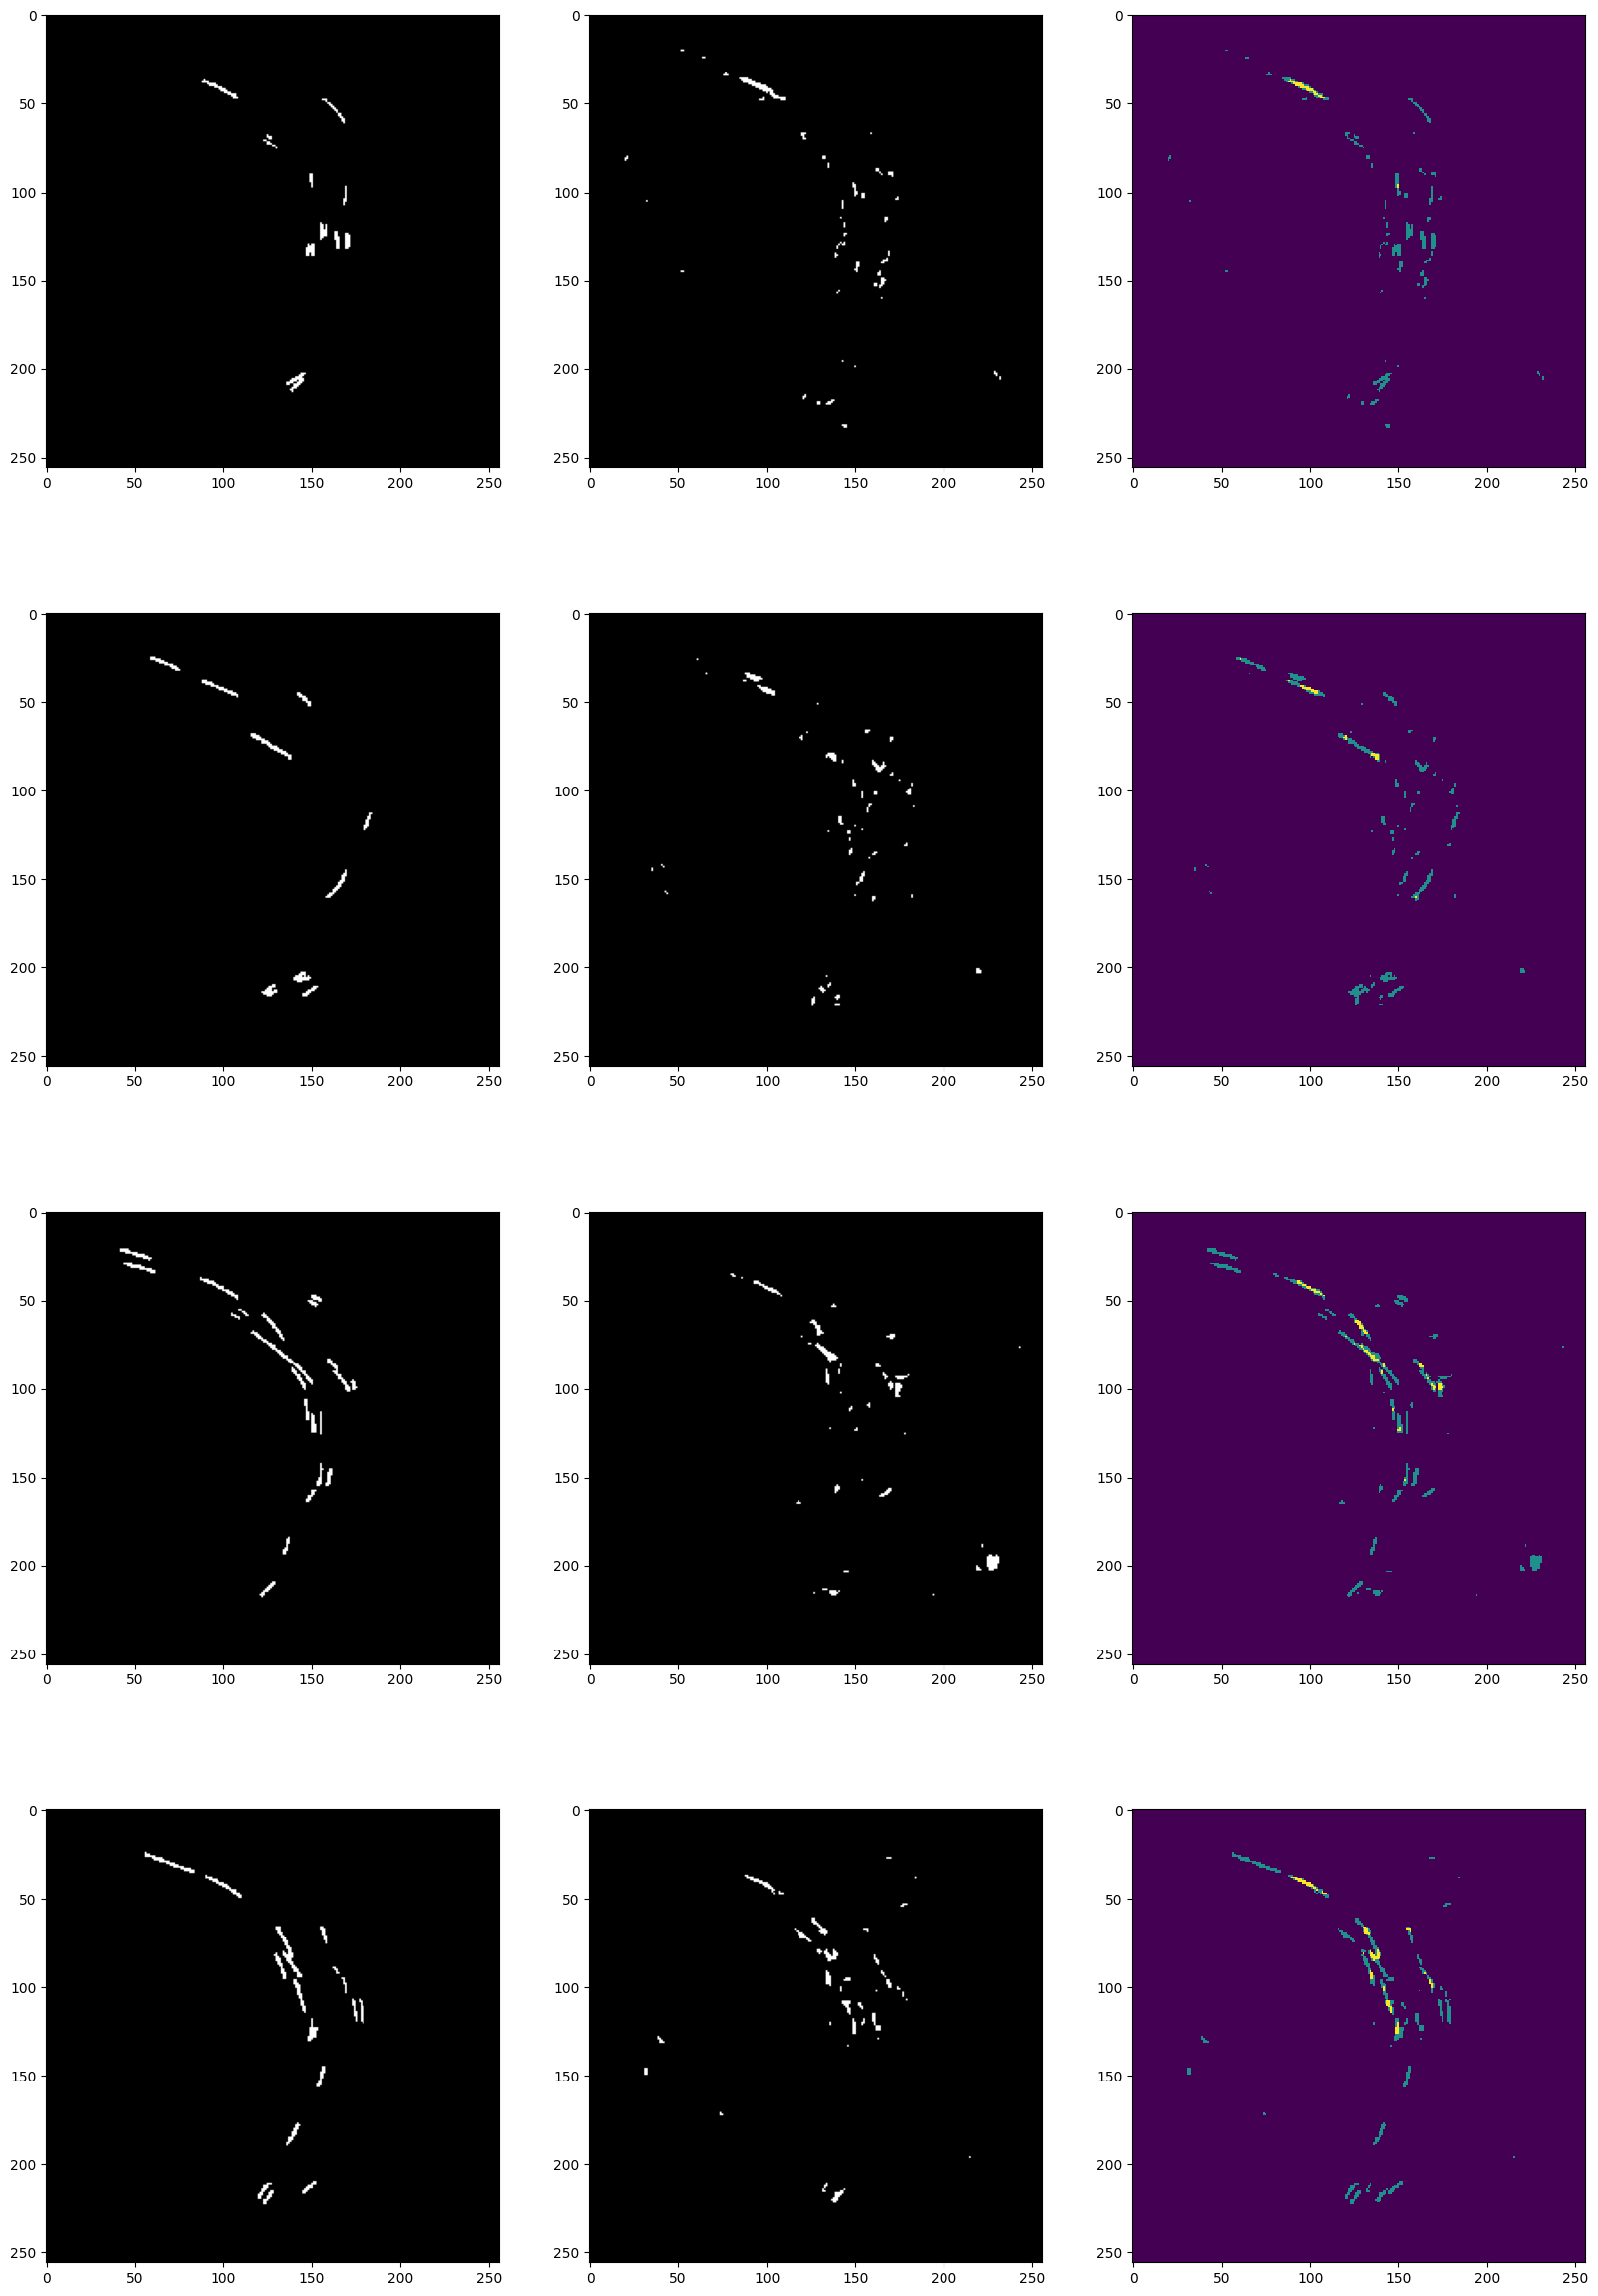

In [9]:
fig = plt.figure(figsize=(20, 30))
a = 0
for loop in range(4):
    for loop2 in range(3):
        a += 1
        ax = fig.add_subplot(4, 3, a)
        if loop2 == 0:
            ax.imshow(np.reshape(masks[loop] * 255, (256, 256)), cmap='gray')
        elif loop2 == 1:
            ax.imshow(np.reshape(result2[loop] * 255, (256, 256)), cmap='gray')
        else:
            ax.imshow(np.reshape((masks[loop] + result2[loop]), (256, 256)), interpolation='none')
plt.savefig('Unet_kfold_deepres/plot_zoom_augmentation_epoch200_nofold_maskval1.png', dpi=200)